**COE241 - Estatística e Modelos Probabilísticos**

COS868 - Probabilidade e Estatística

Segundo Semestre de 2025

Profª: Rosa Maria Meri Leão

Projeto do Curso - Primeira Parte

**1. Objetivo**

O objetivo deste trabalho é aplicar a teoria de Estatística, Máxima Verossimilhança e Inferência Bayesiana a um conjunto de dados real. É essencial que seja realizada uma análise e interpretação dos resultados encontrados em todas as etapas.

O dataset a ser analisado contém medições de parâmetros de conexões da Internet.
As análises incluem:

* Calcular estatísticas descritivas e elaborar gráficos exploratórios.
* Ajustar modelos paramétricos utilizando a Máxima Verossimilhança (MLE).
* Realizar inferência bayesiana com priors conjugadas para obter as posteriors e
previsões.
* Comparar as estimativas MLE vs Bayes.

**2. Conjuntos de Dados**

####M-Lab NDT (Medições de desempenho de rede Internet)
Este dataset possui dados de desempenho de rede (throughput, RTT, perda de pacotes)
com acesso público via BigQuery. Para este projeto, será usado um subconjunto.
* O conjunto de dados será fornecido no arquivo *ndt_tests_tratado.csv*.
* As variáveis incluem: **throughput** de download e upload (em bits por segundo), **RTT** de download e upload (em segundos) e **fração de perda de pacotes** (percentual).
* O dataset possui 13 clientes e 7 servidores. A primeira coluna contém a data e a hora da coleta dos dados.

In [ ]:
# Importação de bibliotecas para utilizar de dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
%matplotlib inline

In [ ]:
# Importação do dataset

df = pd.read_csv('/content/ndt_tests_corrigido.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
# Visualização das primeiras linhas do dataset:

print(df.head(5))

                       timestamp  download_throughput_bps  rtt_download_sec  upload_throughput_bps  rtt_upload_sec  packet_loss_percent    client    server
0  2025-08-09 15:28:02.000 +0000             8.223657e+07          0.231862           6.973217e+07        0.247727             0.000000  client12  server06
1  2025-08-09 15:30:11.000 +0000             9.027315e+08          0.012000           8.521780e+08        0.005423             0.008226  client01  server07
2  2025-08-10 04:27:43.000 +0000             5.910655e+08          0.014000           2.812188e+08        0.014544             5.954284  client13  server07
3  2025-08-09 22:45:07.000 +0000             6.721139e+08          0.011000           1.135400e+08        0.010482             0.261528  client12  server07
4  2025-08-10 04:49:21.000 +0000             8.122087e+08          0.009000           6.857905e+08        0.009368             1.381646  client03  server03


In [ ]:
# Informações gerais do dataset:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7087 entries, 0 to 7086
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                7087 non-null   object 
 1   download_throughput_bps  7087 non-null   float64
 2   rtt_download_sec         7087 non-null   float64
 3   upload_throughput_bps    7087 non-null   float64
 4   rtt_upload_sec           7087 non-null   float64
 5   packet_loss_percent      7087 non-null   float64
 6   client                   7087 non-null   object 
 7   server                   7087 non-null   object 
dtypes: float64(5), object(3)
memory usage: 443.1+ KB
None


In [ ]:
# Algumas Estatísticas descritivas do dataset:

print(df.describe())

       download_throughput_bps  rtt_download_sec  upload_throughput_bps  rtt_upload_sec  packet_loss_percent
count             7.087000e+03       7087.000000           7.087000e+03     7087.000000          7087.000000
mean              5.062996e+08          0.048447           3.781607e+08        0.037194             1.899137
std               3.352129e+08          0.067859           3.014096e+08        0.063537             3.449941
min              -1.000000e+00         -0.001000          -1.000000e+00       -1.000000            -1.000000
25%               1.642170e+08          0.008000           9.733497e+07        0.004918             0.001484
50%               5.960927e+08          0.011549           2.979242e+08        0.010858             0.189771
75%               8.489080e+08          0.115000           6.701694e+08        0.017723             2.050781
max               9.332671e+08          0.398051           9.214500e+08        0.360227            22.389090


**3. Tarefas do Projeto**

**3.1 Análise Exploratória de Dados (EDA)**


* Calcule as estatísticas descritivas: média, mediana, variância, desvio padrão, e
quantis selecionados (por exemplo, 0,9, 0,99, etc.). Justifique a escolha dos
quantis mais relevantes para a análise de desempenho de rede (por exemplo, observar a cauda da latência).
* As estatísticas devem ser calculadas para cada variável de interesse (throughput, RTT e fração de perda), para cada cliente e cada servidor. Elabore tabelas de
resumo e comente as diferenças observadas entre os clientes e entre os servidores.

* Selecione dois clientes ou um cliente e um servidor que apresentem compor-
tamentos distintos ou interessantes para as análises gráficas e modelagem.

* Para os clientes e servidores selecionados, crie os gráficos: histograma, boxplot, scatter plot (escolha um par de variáveis relevante). Analise e comente as distribuições observadas.

* A partir dos gráficos, defina um modelo paramétrico candidato (e.g., Normal,
Gamma, Binomial, etc.) para cada uma das cinco variáveis: throughput (up e
down), RTT (up e down) e perda.

In [ ]:
def contar_clientes(df):
    clientes_unicos = df['client'].unique()
    num_clientes = len(clientes_unicos)

    return clientes_unicos, num_clientes;

clientes_unicos, num_clientes = contar_clientes(df)
print(f"📡 Número total de clientes únicos: {num_clientes}")

📡 Número total de clientes únicos: 13


In [ ]:
def contar_servidores(df):
    servidores_unicos = df['server'].unique()
    num_servidores = len(servidores_unicos)

    return servidores_unicos, num_servidores;

# Chamar a função
servidores_unicos, num_servidores = contar_servidores(df)
print(f"📡 Número total de servidores únicos: {num_servidores}")


📡 Número total de servidores únicos: 7


Escolha de quantis:
* Cauda direita (valores altos) → latência → indica problemas de atraso ou congestionamento.

* Cauda esquerda (valores baixos) → throughput, pacotes, desempenho de download/upload → indica usuários com desempenho ruim ou falhas na rede.

Se o foco é desempenho de rede, é bom analisar quantis que permitam observar a cauda da latência. Portanto 0.9 (90º percentil) mostra a latência alta típica, ou seja, 90% das medições são menores que esse valor.

Throughput (download/upload) → o quantil 0.1 mostra os 10% de usuários com menor desempenho, o que ajuda a identificar casos de gargalos na rede.

Pacotes recebidos ou transferidos → quantil 0.1 (10% percentil) pode representar falhas ou perdas significativas mas tambem analisar 90% para importante para confiabilidade da rede

In [ ]:
#Para todos os clientes:
def calcular_estatisticas(df):
    df_num = df.select_dtypes(include='number')

    resultados = {}
    for col in df_num.columns:
        resultados[col] = {
            'mean': df[col].mean(),
            'median': df[col].median(),
            'var': df[col].var(),
            'std': df[col].std(),
            'q10': df[col].quantile(0.1),
            'q90': df[col].quantile(0.9)
        }

    tabela = pd.DataFrame(resultados).T

    # Arredonda para 2 casas decimais e desativa notação científica
    tabela = tabela.applymap(lambda x: f"{x:.3e}")

    return tabela

tabela = calcular_estatisticas(df)
tabela

/tmp/ipython-input-2772148800.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabela = tabela.applymap(lambda x: f"{x:.3e}")


,mean,median,var,std,q10,q90
download_throughput_bps,5.063e+08,5.961e+08,1.124e+17,3.352e+08,8.608e+07,9.082e+08
rtt_download_sec,4.845e-02,1.155e-02,4.605e-03,6.786e-02,4.000e-03,1.221e-01
upload_throughput_bps,3.782e+08,2.979e+08,9.085e+16,3.014e+08,4.540e+07,8.452e+08
rtt_upload_sec,3.719e-02,1.086e-02,4.037e-03,6.354e-02,3.436e-03,1.198e-01
packet_loss_percent,1.899e+00,1.898e-01,1.190e+01,3.450e+00,0.000e+00,6.295e+00
perdas_contagem,1.899e+01,1.898e+00,1.190e+03,3.450e+01,0.000e+00,6.295e+01


In [ ]:
# Função para calcular estatísticas por grupo
def estatisticas_personalizadas(grupo):
    resultados = {}
    for metrica in metricas:
        resultados[f'{metrica}_mean'] = grupo[metrica].mean()
        resultados[f'{metrica}_median'] = grupo[metrica].median()
        resultados[f'{metrica}_var'] = grupo[metrica].var()
        resultados[f'{metrica}_std'] = grupo[metrica].std()
        for q in quantis:
            resultados[f'{metrica}_q{int(q*100)}'] = grupo[metrica].quantile(q)

    resultados = {k: f"{v:.3e}" for k, v in resultados.items()}

    return pd.Series(resultados)

estatisticas = ['mean', 'median', 'var', 'std'];

In [ ]:
metricas = [
    'download_throughput_bps',
    #'upload_throughput_bps',
    #'rtt_download_sec',
    #'rtt_upload_sec',
    #'packet_loss_percent'
    ]

quantis = [ 0.1, 0.9]

# Estatísticas por CLIENTE
estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_cliente)

# Estatísticas por SERVIDOR
estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_servidor)

/tmp/ipython-input-1615899815.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()


,client,download_throughput_bps_mean,download_throughput_bps_median,download_throughput_bps_var,download_throughput_bps_std,download_throughput_bps_q10,download_throughput_bps_q90
0,client01,6.503e+08,8.928e+08,1.195e+17,3.457e+08,1.712e+08,9.147e+08
1,client02,6.393e+08,8.243e+08,1.059e+17,3.255e+08,1.704e+08,9.113e+08
2,client03,6.133e+08,8.124e+08,1.093e+17,3.306e+08,1.680e+08,9.097e+08
3,client04,5.806e+08,7.992e+08,1.200e+17,3.464e+08,1.606e+08,9.087e+08
4,client05,3.095e+08,1.070e+08,1.121e+17,3.348e+08,9.919e+07,8.925e+08
5,client06,6.113e+08,8.302e+08,1.160e+17,3.407e+08,1.704e+08,9.081e+08
6,client07,6.297e+08,8.344e+08,1.104e+17,3.323e+08,1.627e+08,9.075e+08
7,client08,2.339e+08,9.640e+07,8.546e+16,2.923e+08,7.589e+07,8.583e+08
8,client09,6.452e+08,8.941e+08,1.233e+17,3.511e+08,1.676e+08,9.189e+08
9,client10,2.318e+08,2.211e+08,2.757e+16,1.660e+08,3.215e+07,4.165e+08


/tmp/ipython-input-1615899815.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()


,server,download_throughput_bps_mean,download_throughput_bps_median,download_throughput_bps_var,download_throughput_bps_std,download_throughput_bps_q10,download_throughput_bps_q90
0,server01,6.422e+08,7.618e+08,7.223e+16,2.688e+08,1.064e+08,9.035e+08
1,server02,6.349e+08,7.618e+08,7.813e+16,2.795e+08,1.056e+08,9.019e+08
2,server03,6.384e+08,7.683e+08,7.766e+16,2.787e+08,1.057e+08,9.039e+08
3,server04,1.966e+08,1.684e+08,3.145e+16,1.774e+08,7.509e+07,5.963e+08
4,server05,2.012e+08,1.688e+08,3.350e+16,1.830e+08,7.792e+07,5.967e+08
5,server06,2.054e+08,1.696e+08,3.637e+16,1.907e+08,7.334e+07,5.968e+08
6,server07,5.852e+08,7.092e+08,1.080e+17,3.286e+08,9.644e+07,9.111e+08


Análise *download_throughput_bps* :
1. Clientes
    * client08, client10
      * médias abaixo do padrão geral
      * q10 baixos indicam casos de throughput crítico
      * menores variancias e desvio padrão, indica comportamento com pouca variação.

    * client01, client02, client09
      * médias acima do padrão geral (considerando todos os clientes)
      * q90 semelhante ao padrão geral.
2. Servidores

    * server01
      * Maior performance, pois médias acima do padrão geral.
    
    * server04
      * Menor performance, pois médias abaixo do padrão geral.

In [ ]:
metricas = [
    #'download_throughput_bps',
    'upload_throughput_bps',
    #'rtt_download_sec',
    #'rtt_upload_sec',
    #'packet_loss_percent'
    ]
quantis = [ 0.1, 0.9]

# Estatísticas por CLIENTE
estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_cliente)

# Estatísticas por SERVIDOR
estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_servidor)

/tmp/ipython-input-992871494.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()


,client,upload_throughput_bps_mean,upload_throughput_bps_median,upload_throughput_bps_var,upload_throughput_bps_std,upload_throughput_bps_q10,upload_throughput_bps_q90
0,client01,7.140e+08,8.789e+08,8.298e+16,2.881e+08,1.842e+08,9.112e+08
1,client02,5.620e+08,6.297e+08,4.507e+16,2.123e+08,1.846e+08,7.573e+08
2,client03,5.212e+08,5.928e+08,4.407e+16,2.099e+08,1.833e+08,7.321e+08
3,client04,5.490e+08,6.223e+08,6.147e+16,2.479e+08,1.793e+08,8.596e+08
4,client05,3.478e+08,1.086e+08,1.235e+17,3.514e+08,9.600e+07,8.987e+08
5,client06,6.065e+08,7.387e+08,6.594e+16,2.568e+08,1.842e+08,8.097e+08
6,client07,4.912e+08,5.508e+08,3.713e+16,1.927e+08,1.776e+08,6.947e+08
7,client08,2.259e+08,9.732e+07,6.238e+16,2.498e+08,8.470e+07,7.104e+08
8,client09,4.527e+08,1.902e+08,1.511e+17,3.887e+08,2.854e+07,9.073e+08
9,client10,3.735e+07,4.076e+07,8.590e+13,9.268e+06,2.316e+07,4.559e+07


/tmp/ipython-input-992871494.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()


,server,upload_throughput_bps_mean,upload_throughput_bps_median,upload_throughput_bps_var,upload_throughput_bps_std,upload_throughput_bps_q10,upload_throughput_bps_q90
0,server01,4.371e+08,4.215e+08,9.676e+16,3.111e+08,4.541e+07,8.955e+08
1,server02,4.406e+08,4.314e+08,1.103e+17,3.321e+08,4.468e+07,8.969e+08
2,server03,4.482e+08,4.518e+08,1.064e+17,3.262e+08,4.521e+07,8.993e+08
3,server04,1.573e+08,1.819e+08,8.206e+15,9.059e+07,3.549e+07,2.978e+08
4,server05,1.583e+08,1.812e+08,8.751e+15,9.355e+07,3.705e+07,3.000e+08
5,server06,1.574e+08,1.813e+08,9.822e+15,9.910e+07,3.541e+07,2.989e+08
6,server07,4.491e+08,5.133e+08,9.298e+16,3.049e+08,5.661e+07,8.377e+08


Análise *upload_throughput_bps* :
1. Clientes
    * client08, client10, client12
      * médias abaixo do padrão geral, sendo a do client10 a pior de todas
      * q10 baixos indicam casos de throughput crítico
      * menores variancias e desvio padrão, indica comportamento com pouca variação.

    * client01, client02
      * médias acima do padrão geral, sendo a do client01 a melhor
      * q10 indica que mesmo os piores testes de upload são altos

Clientes de alta performance têm média e quantis altos, mas variancia e desvio padrao mais altos. Clientes de baixa performance possuem upload limitado, já que alguns possuem até mesmo o q90 é baixo.

2. Servidores

    * server03
      * Maior performance, pois médias acima do padrão geral e mediana consistente com a média.
    
    * server04 e 06
      * Menor performance, pois médias abaixo do padrão geral, com medianas consistentes com a média, porem server04 ainda possui menor variancia indicando performance ruim com pouca variacao. Além de q90 abaixo do padrao geral, mesmo para os 90% maiores dados de upload.


In [ ]:
quantis = [ 0.9]

In [ ]:
metricas = [
    #'download_throughput_bps',
    #'upload_throughput_bps',
    'rtt_download_sec',
    #'rtt_upload_sec',
    #'packet_loss_percent'
    ]

# Estatísticas por CLIENTE
estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_cliente)

# Estatísticas por SERVIDOR
estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_servidor)

/tmp/ipython-input-4145260596.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()


,client,rtt_download_sec_mean,rtt_download_sec_median,rtt_download_sec_var,rtt_download_sec_std,rtt_download_sec_q90
0,client01,4.490e-02,1.100e-02,2.887e-03,5.373e-02,1.205e-01
1,client02,3.906e-02,1.000e-02,2.748e-03,5.242e-02,1.186e-01
2,client03,4.445e-02,1.000e-02,3.161e-03,5.622e-02,1.200e-01
3,client04,5.085e-02,1.200e-02,3.052e-03,5.524e-02,1.220e-01
4,client05,4.517e-02,1.000e-02,3.010e-03,5.486e-02,1.190e-01
5,client06,4.676e-02,9.945e-03,3.196e-03,5.654e-02,1.190e-01
6,client07,4.629e-02,1.300e-02,3.320e-03,5.762e-02,1.227e-01
7,client08,5.442e-02,1.000e-02,4.539e-03,6.737e-02,1.200e-01
8,client09,4.497e-02,1.000e-02,3.012e-03,5.488e-02,1.196e-01
9,client10,8.720e-02,1.527e-02,1.070e-02,1.034e-01,2.306e-01


/tmp/ipython-input-4145260596.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()


,server,rtt_download_sec_mean,rtt_download_sec_median,rtt_download_sec_var,rtt_download_sec_std,rtt_download_sec_q90
0,server01,1.129e-02,1.100e-02,5.208e-06,2.282e-03,1.442e-02
1,server02,1.138e-02,1.100e-02,6.971e-06,2.640e-03,1.500e-02
2,server03,1.147e-02,1.100e-02,6.101e-06,2.470e-03,1.500e-02
3,server04,1.276e-01,1.184e-01,4.460e-03,6.678e-02,2.239e-01
4,server05,1.231e-01,1.189e-01,4.574e-03,6.763e-02,2.235e-01
5,server06,1.294e-01,1.188e-01,5.038e-03,7.098e-02,2.277e-01
6,server07,2.961e-02,9.000e-03,2.880e-03,5.367e-02,1.170e-01


Análise *rtt_download_sec*:

1. Clientes

    * client11, client13
      * latência média muito baixa, q90 baixo indicando que mesmo os piores casos de latência são baixos, clientes com desempenho pareciso sendo o client13 melhor.
      * baixa variancia e desvio, rede estável.

    * client10, client12
      * Piores clientes pois possui maior valor médio de latencia e maior q90, picos de latencia significativos (desvio padrao), comportamento instável.

2. Servidores

    * server01

      * Melhor servidor, pois possui menor q90, indicando que os 10% maiores valores de latencia sao aceitaveis.
      * Latência baixa e std baixo, rede estável.

    * server06

      * Pior servidor, maior média e maior q90, indicando que os 10% maiores valores de latencia sao muito altos.

      * Latência alta nos picos e std alto, indicando instabilidade significativa.

Servidores de melhor performance apresentam RTT baixo e consistente, enquanto os de pior performance apresentam picos de latência altos e variância elevada, destacando gargalos na rede.

In [ ]:
metricas = [
    #'download_throughput_bps',
    #'upload_throughput_bps',
    #'rtt_download_sec',
    'rtt_upload_sec',
    #'packet_loss_percent'
    ]


# Estatísticas por CLIENTE
estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_cliente)

# Estatísticas por SERVIDOR
estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_servidor)

/tmp/ipython-input-2827489809.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()


,client,rtt_upload_sec_mean,rtt_upload_sec_median,rtt_upload_sec_var,rtt_upload_sec_std,rtt_upload_sec_q90
0,client01,3.130e-02,6.363e-03,2.170e-03,4.658e-02,1.200e-01
1,client02,2.935e-02,4.243e-03,2.319e-03,4.815e-02,1.174e-01
2,client03,3.299e-02,4.359e-03,2.554e-03,5.053e-02,1.190e-01
3,client04,3.519e-02,8.341e-03,4.895e-03,6.996e-02,1.213e-01
4,client05,2.971e-02,4.112e-03,2.236e-03,4.729e-02,1.186e-01
5,client06,3.178e-02,3.858e-03,4.665e-03,6.830e-02,1.185e-01
6,client07,3.464e-02,8.962e-03,2.666e-03,5.163e-02,1.224e-01
7,client08,4.078e-02,5.875e-03,3.861e-03,6.214e-02,1.200e-01
8,client09,3.394e-02,4.345e-03,2.561e-03,5.061e-02,1.191e-01
9,client10,6.773e-02,1.656e-02,8.788e-03,9.374e-02,2.335e-01


/tmp/ipython-input-2827489809.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()


,server,rtt_upload_sec_mean,rtt_upload_sec_median,rtt_upload_sec_var,rtt_upload_sec_std,rtt_upload_sec_q90
0,server01,1.264e-02,1.114e-02,1.616e-05,4.020e-03,1.897e-02
1,server02,1.130e-02,1.125e-02,1.800e-03,4.243e-02,2.014e-02
2,server03,1.294e-02,1.120e-02,1.860e-05,4.312e-03,2.008e-02
3,server04,1.291e-01,1.189e-01,4.596e-03,6.780e-02,2.314e-01
4,server05,1.240e-01,1.188e-01,4.738e-03,6.884e-02,2.281e-01
5,server06,1.288e-01,1.190e-01,7.510e-03,8.666e-02,2.324e-01
6,server07,7.644e-03,5.448e-03,2.621e-05,5.120e-03,1.524e-02


Análise *rtt_upload_sec* :

1. Clientes

    * client11 e client13
      * Melhor cliente é o 13, com menor medias de latencia na rede, e q90 baixos, indicando picos de latencia baixos, além de baixa variancia.

    * client12
      * latencia média elevada, picos muito altos, especialmente se comparados com o melhor cliente, grande variação nos testes.

2. Servidores

    * server07
      * menor latencia média e consistente com mediana, e menor q90, indicando picos de latencia muito baixos, além de rede estavel pois variancia e desvio sao menores.

    * server06
      * pior servidor, com maior latencia média, picos de latencia elevados (q90), e grande variacao nos dados.

In [ ]:
metricas = [
    #'download_throughput_bps',
    #'upload_throughput_bps',
    #'rtt_download_sec',
    #'rtt_upload_sec',
    'packet_loss_percent'
    ]


# Estatísticas por CLIENTE
estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_cliente)

# Estatísticas por SERVIDOR
estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()
display(estatisticas_servidor)

/tmp/ipython-input-2383472902.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_cliente = df.groupby('client').apply(estatisticas_personalizadas).reset_index()


,client,packet_loss_percent_mean,packet_loss_percent_median,packet_loss_percent_var,packet_loss_percent_std,packet_loss_percent_q90
0,client01,5.241e-01,5.476e-03,2.785e+00,1.669e+00,7.665e-01
1,client02,7.814e-01,6.545e-02,3.533e+00,1.880e+00,1.814e+00
2,client03,6.750e-01,7.492e-02,2.067e+00,1.438e+00,1.633e+00
3,client04,5.128e-01,4.932e-02,1.730e+00,1.315e+00,1.125e+00
4,client05,6.312e+00,8.276e+00,2.805e+01,5.296e+00,1.264e+01
5,client06,8.322e-01,7.171e-01,1.035e+00,1.017e+00,1.834e+00
6,client07,5.297e-01,8.759e-02,2.430e+00,1.559e+00,9.957e-01
7,client08,5.061e+00,3.335e+00,3.696e+01,6.079e+00,1.847e+01
8,client09,4.833e-01,7.307e-02,1.918e+00,1.385e+00,7.198e-01
9,client10,1.480e+00,7.470e-03,8.282e+00,2.878e+00,6.293e+00


/tmp/ipython-input-2383472902.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estatisticas_servidor = df.groupby('server').apply(estatisticas_personalizadas).reset_index()


,server,packet_loss_percent_mean,packet_loss_percent_median,packet_loss_percent_var,packet_loss_percent_std,packet_loss_percent_q90
0,server01,2.257e+00,1.017e+00,7.854e+00,2.803e+00,6.435e+00
1,server02,1.978e+00,7.935e-01,8.136e+00,2.852e+00,6.274e+00
2,server03,2.130e+00,8.350e-01,8.557e+00,2.925e+00,6.456e+00
3,server04,1.939e+00,0.000e+00,1.578e+01,3.973e+00,6.353e+00
4,server05,2.747e+00,0.000e+00,2.687e+01,5.183e+00,1.086e+01
5,server06,1.949e+00,0.000e+00,1.796e+01,4.238e+00,6.415e+00
6,server07,1.665e+00,8.925e-02,9.697e+00,3.114e+00,5.837e+00


Análise *packet_loss_percent* :

1. Clientes

      * client01, client12
        * menores perdas médias, q90 baixo indicando poucos picos de perda de pacotes, baixa variacao, principalmente no cliente12.

      * client05, client08, client13
        * alta perda média de pacotes, grande variacao nos dados, sendo client08 com maior variancia e maior q90, indicando picos grandes de perda de pacote, o que afeta a confiabilidade da comunicacao. enquanto client05 possui maior media.


2. Servidores

      * server07 e server02
        * melhores servidores, pois possuem menor media, picos baixos representados pelo q90, e variancia moderada, sendo o melhor o server07.


      * server01 e server05
        * piores valores, com maior média, picos altos de perda e grande variabilidade nos dados. sendo o server05 o pior em termos de media, q90 e variancia.


Escolha de clientes com comportamento distinto:
  * client02, aprensenta um throughput bom com valores acima da media, apresenta as valores abaixo da média para latencia e é um cliente com baixa perda de pacotes.
  * client12, aprensenta um throughput nao tão bom com valores abaixo da media, apresenta as piores latencia no geral, mas também é um cliente com baixa perda de pacotes.
  


Plotando graficos para os clientes escolhidos:

1. Throughput download

In [ ]:
variaveis = {
    "download_throughput_bps": "Throughput Download (bps)",
    "upload_throughput_bps": "Throughput Upload (bps)",
    "rtt_download_sec": "RTT Download (s)",
    "rtt_upload_sec": "RTT Upload (s)",
    "packet_loss_percent": "Perda de Pacotes (%)"
}

In [ ]:
clientes = df[df["client"].isin(["client02", "client12"])]

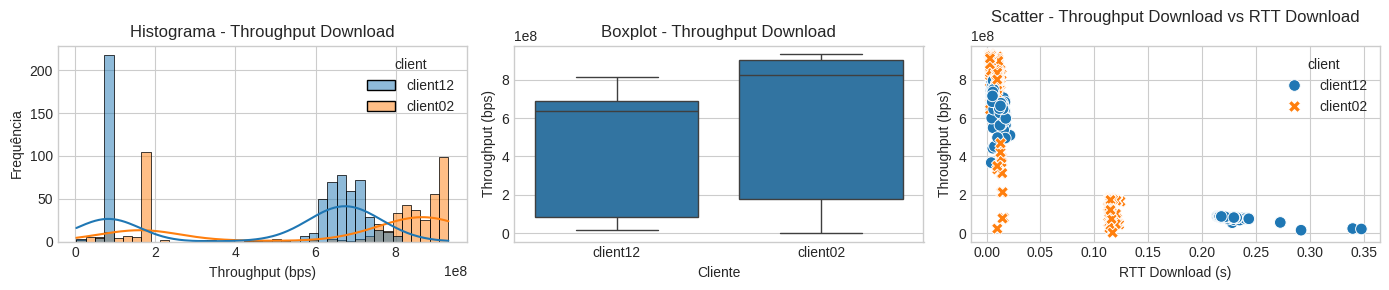

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# Histograma - Download
sns.histplot(data=clientes, x="download_throughput_bps", hue="client", kde=True, bins=40, alpha=0.5, ax=axes[0])
axes[0].set_title("Histograma - Throughput Download")
axes[0].set_xlabel("Throughput (bps)")
axes[0].set_ylabel("Frequência")

# Boxplot - Download
sns.boxplot(data=clientes, x="client", y="download_throughput_bps", ax=axes[1])
axes[1].set_title("Boxplot - Throughput Download")
axes[1].set_xlabel("Cliente")
axes[1].set_ylabel("Throughput (bps)")

# Scatter plot - Download vs RTT Download
sns.scatterplot(data=clientes, x="rtt_download_sec", y="download_throughput_bps", hue="client", style="client", s=70, ax=axes[2])
axes[2].set_title("Scatter - Throughput Download vs RTT Download")
axes[2].set_xlabel("RTT Download (s)")
axes[2].set_ylabel("Throughput (bps)")

plt.tight_layout()
plt.show()

  Pelo histograma é possivel ver que os dados sao mais distribuidos em valores altos, contudo o cliente possui um pico em valores baixos, o que é era esperado já que foi analizado como um candidato que tinha throughput ruim. Já o cliente 02, tambem possui um pico em valores baixos, mas com menor frequencia e possui valores mais altos com mais frequencia. Pela analise do grafico é possivel observar uma distribuição bimodal, portanto um modelo composto por duas gammas pode se ajustar bem a essa variavel.



2. Throughput upload

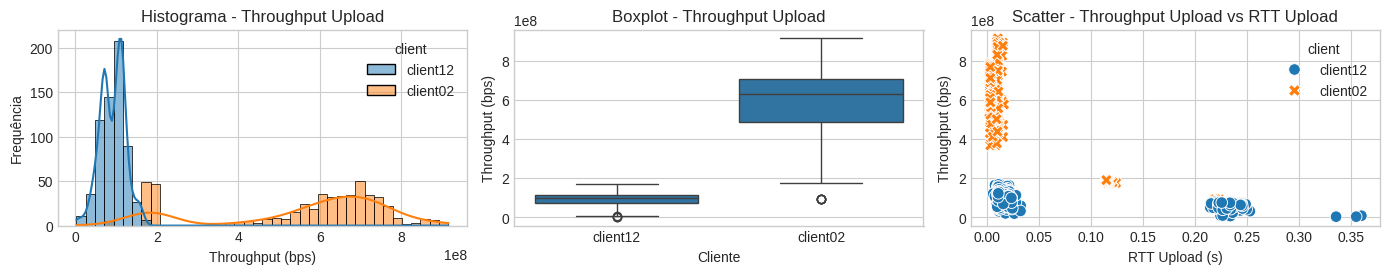

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# Histograma - Upload
sns.histplot(data=clientes, x="upload_throughput_bps", hue="client", kde=True, bins=40, alpha=0.5, ax=axes[0])
axes[0].set_title("Histograma - Throughput Upload")
axes[0].set_xlabel("Throughput (bps)")
axes[0].set_ylabel("Frequência")

# Boxplot - Upload
sns.boxplot(data=clientes, x="client", y="upload_throughput_bps", ax=axes[1])
axes[1].set_title("Boxplot - Throughput Upload")
axes[1].set_xlabel("Cliente")
axes[1].set_ylabel("Throughput (bps)")

# Scatter plot - Upload vs RTT Upload
sns.scatterplot(data=clientes, x="rtt_upload_sec", y="upload_throughput_bps", hue="client", style="client", s=70, ax=axes[2])
axes[2].set_title("Scatter - Throughput Upload vs RTT Upload")
axes[2].set_xlabel("RTT Upload (s)")
axes[2].set_ylabel("Throughput (bps)")

plt.tight_layout()
plt.show()

  Pelo histograma é possivel ver que os dados sao distribuidos mais uniformemente para upload. O cliente 12 tem desempenho baixo a todo momento, com frequencia alta em valores baixos de throughput. enquanto cliente 2 possui dois picos, mas maior concentracao em valores altos. Alguns outliers aparecem no grafico de boxplot para o pico com valores inferiores. Dessa forma, um modelo composto por uma variavel gamma ou normal pode se adequar bem nesse caso. Seguindo a sugestao da da seção 4.3, vai ser adotado a distribuição gamma para ambos throughputs, download e upload.

3. RTT download

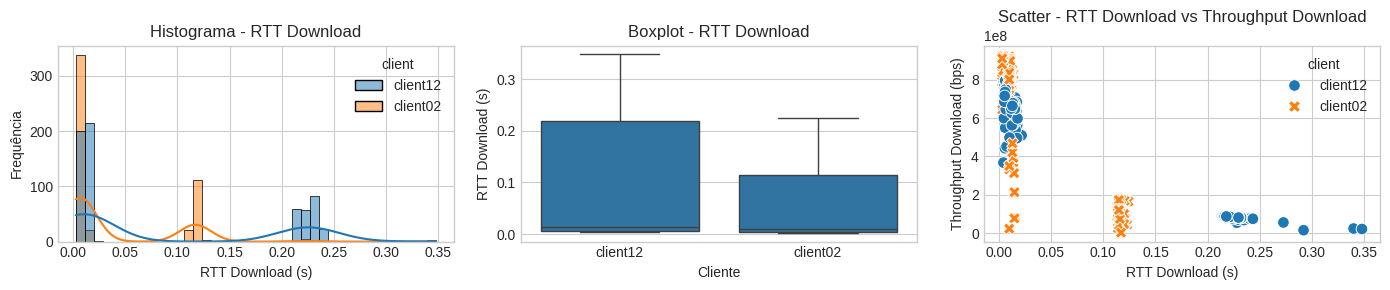

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# Histograma - RTT Download
sns.histplot(data=clientes, x="rtt_download_sec", hue="client", kde=True, bins=40, alpha=0.5, ax=axes[0])
axes[0].set_title("Histograma - RTT Download")
axes[0].set_xlabel("RTT Download (s)")
axes[0].set_ylabel("Frequência")

# Boxplot - RTT Download
sns.boxplot(data=clientes, x="client", y="rtt_download_sec", ax=axes[1])
axes[1].set_title("Boxplot - RTT Download")
axes[1].set_xlabel("Cliente")
axes[1].set_ylabel("RTT Download (s)")

# Scatter plot - RTT Download vs Throughput Download
sns.scatterplot(data=clientes, x="rtt_download_sec", y="download_throughput_bps", hue="client", style="client", s=70, ax=axes[2])
axes[2].set_title("Scatter - RTT Download vs Throughput Download")
axes[2].set_xlabel("RTT Download (s)")
axes[2].set_ylabel("Throughput Download (bps)")

plt.tight_layout()
plt.show()

Também apresenta distribuicao bimodal, mas o cliente 02 com valores baixos de latencia enquanto o cliente 12 tem valores altos de latencia com maior frequencia, mas tambem opera em valores baixos. essa situacao pode indicar diferentes condicoes na rede, já que ambos os clientes tem essa caracteristica bimodal na distribuicao. Também é possivel observar uma presenca de cauda longa a direita, o que pode indicar possivelmente um modelo composto por gamma já que sao sempre positivas e tendencia de valores com menor frequencia a direita, portando como existe bimodalidade, possivelmente uma gamma ou normal ou uma composicao de duas do mesmo tipo faz sentido.

Portanto, como sugerido na seção 4.1, vai ser adotado a distribuição normal para ambos RTT download e upload.

4. RTT upload

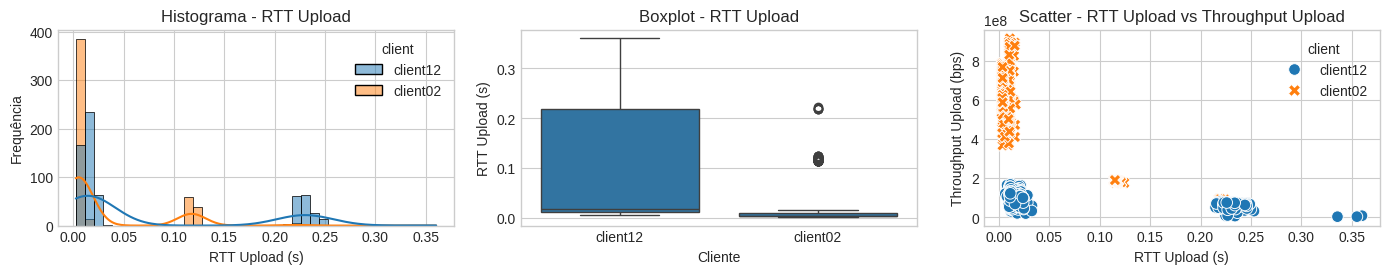

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# Histograma - RTT Upload
sns.histplot(data=clientes, x="rtt_upload_sec", hue="client", kde=True, bins=40, alpha=0.5, ax=axes[0])
axes[0].set_title("Histograma - RTT Upload")
axes[0].set_xlabel("RTT Upload (s)")
axes[0].set_ylabel("Frequência")

# Boxplot - RTT Upload
sns.boxplot(data=clientes, x="client", y="rtt_upload_sec", ax=axes[1])
axes[1].set_title("Boxplot - RTT Upload")
axes[1].set_xlabel("Cliente")
axes[1].set_ylabel("RTT Upload (s)")

# Scatter plot - RTT Upload vs Throughput Upload
sns.scatterplot(data=clientes, x="rtt_upload_sec", y="upload_throughput_bps", hue="client", style="client", s=70, ax=axes[2])
axes[2].set_title("Scatter - RTT Upload vs Throughput Upload")
axes[2].set_xlabel("RTT Upload (s)")
axes[2].set_ylabel("Throughput Upload (bps)")

plt.tight_layout()
plt.show()


Mesmo caso observado em latencia de download mas aqui o pico com maior latencia possui ainda menor frequencia, indicando que um modelo utilizando gamma ou normal é uma escolha razoavel. Pelo grafico de blocpot também podemos observar que faz sentido já que existem muitos outliers fora dos quartis, e que os valores sao concentrados em latencia baixa, principalmente para o cliente 2.

5. loss packages

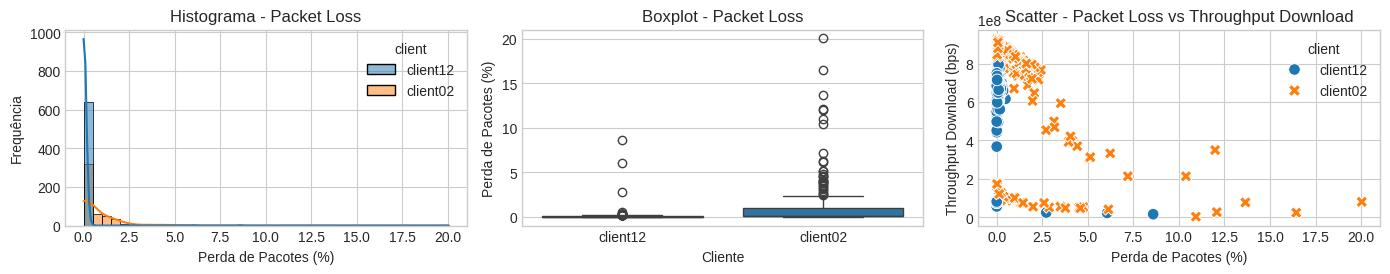

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# Histograma - Packet Loss
sns.histplot(data=clientes, x="packet_loss_percent", hue="client", kde=True, bins=40, alpha=0.5, ax=axes[0])
axes[0].set_title("Histograma - Packet Loss")
axes[0].set_xlabel("Perda de Pacotes (%)")
axes[0].set_ylabel("Frequência")

# Boxplot - Packet Loss
sns.boxplot(data=clientes, x="client", y="packet_loss_percent", ax=axes[1])
axes[1].set_title("Boxplot - Packet Loss")
axes[1].set_xlabel("Cliente")
axes[1].set_ylabel("Perda de Pacotes (%)")

# Scatter plot - Packet Loss vs Throughput Download
sns.scatterplot(data=clientes, x="packet_loss_percent", y="download_throughput_bps", hue="client", style="client", s=70, ax=axes[2])
axes[2].set_title("Scatter - Packet Loss vs Throughput Download")
axes[2].set_xlabel("Perda de Pacotes (%)")
axes[2].set_ylabel("Throughput Download (bps)")

plt.tight_layout()
plt.show()


Para porcentagem de perda de pacotes, uma distribuicao gamma poderia se aplicar desde que é visivel a cauda longa a direita, com concentracao alta em valores baixos de perda. Contudo o domínio da gamma é de (0, infinito), e como essa variavel é representada em porcentagem, ou seja, contem apenas valores entre 0 e 1, um modelo utilizando beta pode ser uma boa alternativa nesse caso. Portando, assim como sugerido na seção 4.2, o modelo a ser adotado é Beta-Binomial.

**3.2 Máxima Verossimilhança (MLE)**

Utilize o método da Máxima Verossimilhança (MLE) para estimar os parâmetros dos
modelos definidos na seção anterior.

* Defina o Estimador de Máxima Verossimilhança $\hat{\theta}_{MLE}$ para cada modelo. Apresente os valores numéricos.

* Avaliação do Ajuste: Crie gráficos comparativos para diagnosticar o ajuste do
modelo:
1. Histograma dos dados reais em conjunto com a função densidade/massa de
probabilidade do modelo ajustado usando o $\hat{\theta}_{MLE}$.
2. QQ plot dos dados reais versus quantis teóricos do modelo ajustado.

**Throughput download e upload (Distribuição Gamma):**

1. Likelihood (Verossimilhança): As observações de throughput $Y = (y_1, \ldots, y_n)$ são modeladas por uma distribuição Gamma com *shape* $k > 0$ (fixo e conhecido) e *rate* $\beta > 0$ (desconhecido).

$$
y_i \mid \beta \sim \text{Gamma}(k, \beta).
\tag{1}
$$

A função densidade de probabilidade (PDF) é:

$$
f(y \mid k, \beta) = \frac{\beta^k}{\Gamma(k)} y^{k-1} e^{-\beta y},
\quad y > 0.
\tag{2}
$$

2. Prior (A Priori): Escolhemos a *prior* conjugada para o parâmetro de taxa $\beta$, que é também uma distribuição Gamma com hiperparâmetros $a_0$ e $b_0$.

$$
\beta \sim \text{Gamma}(a_0, b_0).
\tag{3}
$$

Próximo passo é encontrar os parametros para cada Throughput download e upload (considerando todos os clientes, e tambem o cliente 02 e 12).

Obs: Como a variavel gama considera apenas valores positivos, o que faz sentido considerando a variavel de throuput, será realizada uma limpeza em dados negativos nessa etapa, de modo que caso existam valores negativos devido a erros de medicao ou qualquer outro motivo, nao seja retornado nenhum tipo de erro na modelagem.


In [ ]:
from scipy.stats import norm, gamma, binom, probplot
from scipy.special import digamma, loggamma, gamma as gamma_func
from scipy.optimize import minimize # Para o MLE manual, se necessário

In [ ]:
df_02 = df[df['client'] == 'client02'].copy()
df_12 = df[df['client'] == 'client12'].copy()

In [ ]:
# Throughput Download utilizando funcao gamma que possui melhor aproximacao de parametros do que caso feito por momento.

th_down = df['download_throughput_bps']
th_down = th_down[th_down > 0]
k_mle_th_down, loc_mle_th_down, scale_mle_th_down = gamma.fit(th_down, floc=0)
beta_mle_th_down = 1 / scale_mle_th_down

th_down_02 = df_02['download_throughput_bps']
th_down_02 = th_down_02[th_down_02 > 0]
k_mle_th_down_02, loc_mle_th_down_02, scale_mle_th_down_02 = gamma.fit(th_down_02, floc=0)
beta_mle_th_down_02 = 1 / scale_mle_th_down_02

th_down_12 = df_12['download_throughput_bps']
th_down_12 = th_down_12[th_down_12 > 0]
k_mle_th_down_12, loc_mle_th_down_12, scale_mle_th_down_12 = gamma.fit(th_down_12, floc=0)
beta_mle_th_down_12 = 1 / scale_mle_th_down_12

#print(f"Throughput Download: Gamma(k={k_mle_th_down:.4f}, beta={beta_mle_th_down:.4e})")
#print(f"Throughput Download: Gamma(k={k_mle_th_down_02:.4f}, beta={beta_mle_th_down_02:.4e}) (client02)")
#print(f"Throughput Download: Gamma(k={k_mle_th_down_12:.4f}, beta={beta_mle_th_down_12:.4e}) (client12)\n")

th_up = df['upload_throughput_bps']
th_up = th_up[th_up > 0]
mle_th_up_k, _, mle_th_up_scale = gamma.fit(th_up, floc=0)
mle_th_up_beta = 1 / mle_th_up_scale

th_up_02 = df_02['upload_throughput_bps']
th_up_02 = th_up_02[th_up_02 > 0]
mle_th_up_k_02, _, mle_th_up_scale_02 = gamma.fit(th_up_02, floc=0)
mle_th_up_beta_02 = 1 / mle_th_up_scale_02

th_up_12 = df_12['upload_throughput_bps']
th_up_12 = th_up_12[th_up_12 > 0]
mle_th_up_k_12, _, mle_th_up_scale_12 = gamma.fit(th_up_12, floc=0)
mle_th_up_beta_12 = 1 / mle_th_up_scale_12

#print(f"Throughput Upload: Gamma(k={mle_th_up_k:.4f}, beta={mle_th_up_beta:.4e})")
#print(f"Throughput Upload: Gamma(k={mle_th_up_k_02:.4f}, beta={mle_th_up_beta_02:.4e}) (client02)")
#print(f"Throughput Upload: Gamma(k={mle_th_up_k_12:.4f}, beta={mle_th_up_beta_12:.4e})(client12)")

In [ ]:
print(f"Throughput Download: Gamma(k, beta)\n")
print(f"client      k         beta")
print(f"all       {k_mle_th_down:.4f}     {beta_mle_th_down:.4e} ")
print(f"02        {k_mle_th_down_02:.4f}     {beta_mle_th_down_02:.4e}")
print(f"12        {k_mle_th_down_12:.4f}     {beta_mle_th_down_12:.4e} ")

Throughput Download: Gamma(k, beta)

client      k         beta
all       1.4957     2.9521e-09 
02        2.1055     3.2933e-09
12        1.4848     3.1948e-09 


In [ ]:
print(f"Throughput Upload: Gamma(k, beta)\n")
print(f"client      k         beta")
print(f"all       {mle_th_up_k:.4f}     {mle_th_up_beta:.4e} ")
print(f"02        {mle_th_up_k_02:.4f}     {mle_th_up_beta_02:.4e}")
print(f"12        {mle_th_up_k_12:.4f}     {mle_th_up_beta_12:.4e} ")

Throughput Upload: Gamma(k, beta)

client      k         beta
all       1.1944     3.1575e-09 
02        4.5116     8.0285e-09
12        6.7581     7.3321e-08 


**RTT download e upload (Distribuição Normal):**

1. Likelihood (Verossimilhança): A distribuição dos dados, condicionada à média $\mu$, é Normal com variância $\sigma^2$ conhecida.

$$
r_i \mid \mu \sim \mathcal{N}(\mu, \sigma^2).
\tag{4}
$$

2. Prior (A Priori): A distribuição a priori para o parâmetro desconhecido μ é
também Normal, caracterizada pela média $\mu_0$ e variância $\tau_0^2$

$$
\mu \sim \mathcal{N}(\mu_0, \tau_0^2).
\tag{5}
$$

Primeiro passo é encontrar os parametros para cada RTT download e upload (considerando todos os clientes).




In [ ]:
from scipy.stats import norm, gamma, binom, probplot
from scipy.special import digamma, loggamma, gamma as gamma_func
from scipy.optimize import minimize # Para o MLE manual, se necessário

In [ ]:
# RTT Download
rtt_down = df['rtt_download_sec']
mle_rtt_down_media, mle_rtt_down_desvio = norm.fit(rtt_down)
mle_rtt_down_variancia = mle_rtt_down_desvio**2

rtt_down_02 = df_02['rtt_download_sec']
mle_rtt_down_media_02, mle_rtt_down_desvio_02 = norm.fit(rtt_down_02)
mle_rtt_down_variancia_02 = mle_rtt_down_desvio_02**2

rtt_down_12 = df_12['rtt_download_sec']
mle_rtt_down_media_12, mle_rtt_down_desvio_12 = norm.fit(rtt_down_12)
mle_rtt_down_variancia_12 = mle_rtt_down_desvio_12**2

#print(f"RTT Download: N({mle_rtt_down_media:.6f}, {mle_rtt_down_variancia:.6f})")
#print(f"RTT Download: N({mle_rtt_down_media_02:.6f}, {mle_rtt_down_variancia_02:.6f}) (client02)")
#print(f"RTT Download: N({mle_rtt_down_media_12:.6f}, {mle_rtt_down_variancia_12:.6f}) (client12)\n")

# RTT Upload
rtt_up = df['rtt_upload_sec']
mle_rtt_up_media, mle_rtt_up_desvio = norm.fit(rtt_up)
mle_rtt_up_variancia = mle_rtt_up_desvio**2

rtt_up_02 = df_02['rtt_upload_sec']
mle_rtt_up_media_02, mle_rtt_up_desvio_02 = norm.fit(rtt_up_02)
mle_rtt_up_variancia_02 = mle_rtt_up_desvio_02**2

rtt_up_12 = df_12['rtt_upload_sec']
mle_rtt_up_media_12, mle_rtt_up_desvio_12 = norm.fit(rtt_up_12)
mle_rtt_up_variancia_12 = mle_rtt_up_desvio_12**2

#print(f"RTT Upload: N({mle_rtt_up_media:.6f}, {mle_rtt_up_variancia:.6f})")
#print(f"RTT Upload: N({mle_rtt_up_media_02:.6f}, {mle_rtt_up_variancia_02:.6f}) (client02)")
#print(f"RTT Upload: N({mle_rtt_up_media_12:.6f}, {mle_rtt_up_variancia_12:.6f}) (client12)")

In [ ]:
print(f"RTT Download: N(mu, sigma^2)\n")
print(f"client      mu        sigma^2")
print(f"all      {mle_rtt_down_media:.6f}    {mle_rtt_down_variancia:.6f} ")
print(f"02       {mle_rtt_down_media_02:.6f}    {mle_rtt_down_variancia_02:.6f} ")
print(f"12       {mle_rtt_down_media_12:.6f}    {mle_rtt_down_variancia_12:.6f} ")

RTT Download: N(mu, sigma^2)

client      mu        sigma^2
all      0.048447    0.004604 
02       0.039058    0.002742 
12       0.086485    0.010765 


In [ ]:
print(f"RTT Upload: N(mu, sigma^2)\n")
print(f"client      mu        sigma^2")
print(f"all      {mle_rtt_up_media:.6f}    {mle_rtt_up_variancia:.6f} ")
print(f"02       {mle_rtt_up_media_02:.6f}    {mle_rtt_up_variancia_02:.6f} ")
print(f"12       {mle_rtt_up_media_12:.6f}    {mle_rtt_up_variancia_12:.6f} ")

RTT Upload: N(mu, sigma^2)

client      mu        sigma^2
all      0.037194    0.004036 
02       0.029352    0.002314 
12       0.073462    0.009452 


**Packege loss (Beta–Binomial):**

A fração de perda de pacotes ($p$) em redes de comunicação é uma proporção que se encontra no intervalo $[0, 1]$. Esta característica torna o modelo Binomial uma escolha natural para a likelihood, com a distribuição Beta servindo como a prior conjugada. O par Beta–Binomial é ideal para inferência Bayesiana sobre proporções.

O modelo é definido pela likelihood Binomial e pela prior Beta para a probabilidade de perda.

1. Likelihood (Verossimilhança): Considere $n_t$ pacotes enviados e $x_t$ pacotes perdidos no período $t$. A contagem de perdas é modelada por uma distribuição Binomial, onde $p$ é a probabilidade de perda em uma transmissão:

$$
X_t \mid p \sim \text{Binomial}(n_t, p).
\tag{6}
$$

Obs: Como o dataset fornece a fração de perda (percentual), e o número
real de pacotes ($n_t$) transmitidos em um teste NDT varia com o throughput e a duração, você deve assumir um número fixo de pacotes transmitidos ($n_t$)
para converter a fração em contagem ($X_t$), permitindo o uso do modelo Binomial. Sugestão de Valor a ser Fixado: Para simplificar a análise, sugere-se assumir um número fixo de pacotes por observação, como, por exemplo, $n_t$ = 1000. O valor de $n_t$ (ou $n_{tot}$, o agregado) deve ser apresentado na seção de Inferência Bayesiana.

2. Prior (A Priori): A distribuição a priori para a probabilidade de perda $p \in [0,1]$  é a distribuição Beta, caracterizada pelos hiperparâmetros $a_0$ e $b_0$.

$$p \sim \text{Beta}(a_0, b_0).
\tag{8}$$

Primeiro passo é encontrar os parametros para essa variavel (considerando todos os clientes).




In [ ]:
# É sugerido fixar um número de pacotes (nt) para converter a fração em contagem Xt .
nt_pacotes = 1000
# A coluna 'packet_loss_percent' é um percentual, deve ser dividida por 100 para obter a fração.
df['perdas_contagem'] = (df['packet_loss_percent'] / 100) * nt_pacotes

df_02['perdas_contagem'] = (df_02['packet_loss_percent'] / 100) * nt_pacotes
df_12['perdas_contagem'] = (df_12['packet_loss_percent'] / 100) * nt_pacotes


In [ ]:
x_tot = df['perdas_contagem'].sum()
n_tot = len(df) * nt_pacotes
mle_loss_p = x_tot / n_tot

x_tot_02 = df_02['perdas_contagem'].sum()
n_tot_02 = len(df_02) * nt_pacotes
mle_loss_p_02 = x_tot_02 / n_tot_02

x_tot_12 = df_12['perdas_contagem'].sum()
n_tot_12 = len(df_12) * nt_pacotes
mle_loss_p_12 = x_tot_12 / n_tot_12

#print(f"Package loss: Binomial(n_t={nt_pacotes}, p={mle_loss_p:.6f})")
#print(f"Package loss: Binomial(n_t={nt_pacotes}, p={mle_loss_p_02:.6f})")
#print(f"Package loss: Binomial(n_t={nt_pacotes}, p={mle_loss_p_12:.6f})")

In [ ]:
print(f"Package loss: Binomial(n_t, p)\n")
print(f"client      n_t        p")
print(f"all        {nt_pacotes}     {mle_loss_p:.6f}")
print(f"02         {nt_pacotes}     {mle_loss_p_02:.6f}")
print(f"12         {nt_pacotes}     {mle_loss_p_02:.6f}")

Package loss: Binomial(n_t, p)

client      n_t        p
all        1000     0.018991
02         1000     0.007814
12         1000     0.007814


Crie gráficos comparativos para diagnosticar o ajuste do
modelo:
1. Histograma dos dados reais em conjunto com a função densidade/massa de
probabilidade do modelo ajustado usando o $\hat{\theta}_{MLE}$.
2. QQ plot dos dados reais versus quantis teóricos do modelo ajustado.

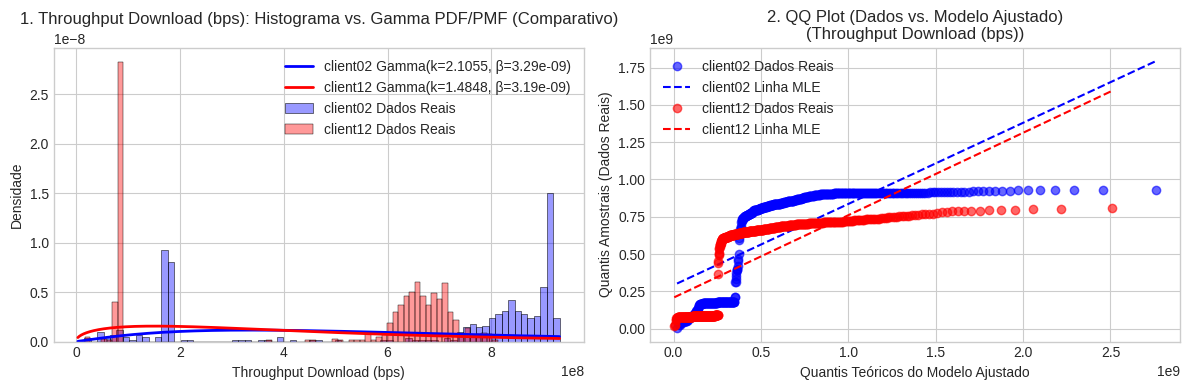

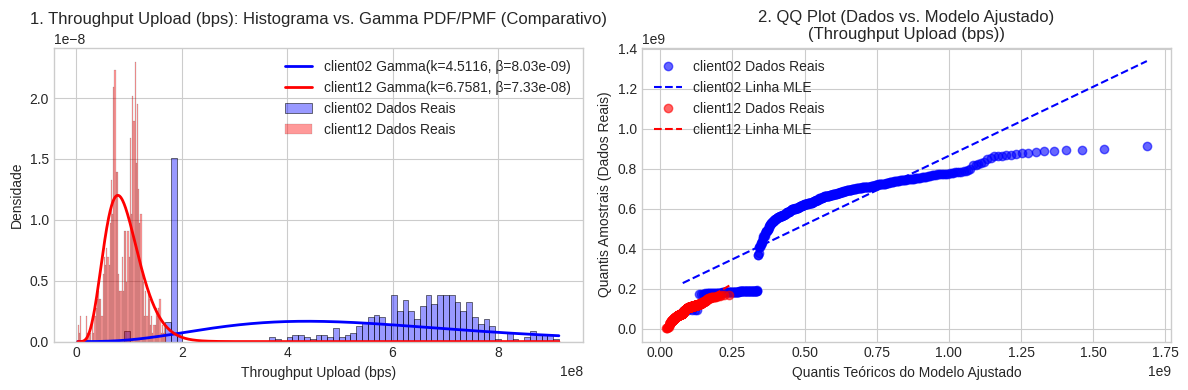

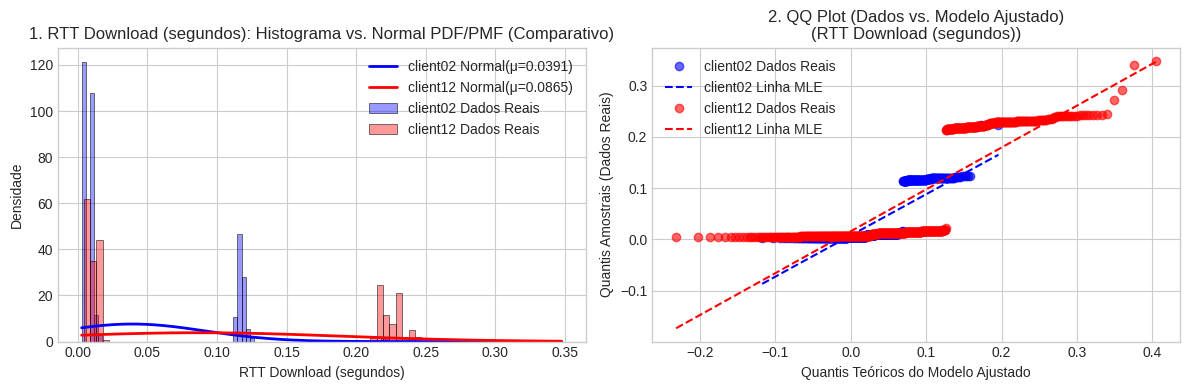

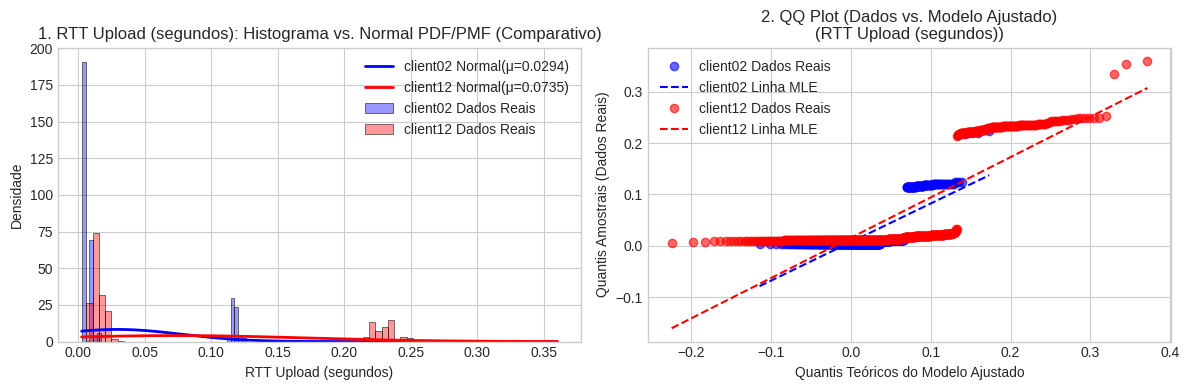

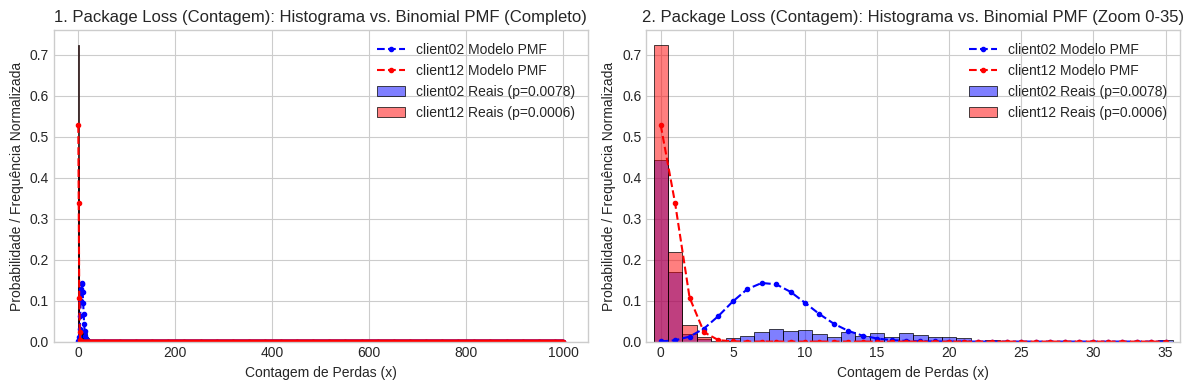

In [ ]:
def plot_mle_comparative_diagnostics(data_dict, distribution_name, param_keys, title):
    """
    Cria e exibe o Histograma vs. PDF/PMF (Subplot 1) e o QQ Plot ou Histograma com Zoom (Subplot 2).
    Ajustado para barras mais finas (mais bins ou visualização discreta).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    COLORS = {'client02': 'blue', 'client12': 'red'}

    # ---------------------------------------------------------------------
    # Subplot 1: Histograma vs. PDF/PMF (Geral)
    # ---------------------------------------------------------------------

    if distribution_name == 'Binomial':
        nt = 1000
        zoom_limit = 35

        # --- Lógica de Plotagem Comum para PMF/Histogramas (Binomial) ---
        def plot_binomial(ax, data_dict, nt, limit=None):
            for client, values in data_dict.items():
                data = values['data']
                p_mle = values['params'][0]
                color = COLORS[client]

                # 1. Histograma dos dados reais: Bins por inteiro, barras bem definidas.
                bins = np.arange(0, nt + 2) - 0.5
                if limit is not None:
                    bins = np.arange(0, limit + 2) - 0.5

                # Usando sns.histplot com ajuste de visualização para barras mais nítidas
                sns.histplot(data, bins=bins, stat="density", alpha=0.5, color=color,
                             ax=ax, label=f'{client} Reais (p={p_mle:.4f})',
                             discrete=True, edgecolor='black', linewidth=0.5)

                # 2. PMF do modelo ajustado
                k = np.arange(0, nt + 1)
                pmf_values = binom.pmf(k, nt, p_mle)

                k_plot = k
                pmf_plot = pmf_values
                if limit is not None:
                    k_plot = k[k <= limit]
                    pmf_plot = pmf_values[k <= limit]

                ax.plot(k_plot, pmf_plot, marker='o', linestyle='--', color=color, markersize=3,
                             label=f'{client} Modelo PMF')

            ax.set_xlabel('Contagem de Perdas (x)')
            ax.set_ylabel('Probabilidade / Frequência Normalizada')
            ax.legend()

        # Plot Subplot 1: Histograma Completo
        plot_binomial(axes[0], data_dict, nt)
        axes[0].set_title(f'1. {title}: Histograma vs. Binomial PMF (Completo)')

        # Plot Subplot 2: Histograma com Zoom (0-50)
        plot_binomial(axes[1], data_dict, nt, limit=zoom_limit)
        axes[1].set_xlim(-1, zoom_limit + 1)
        axes[1].set_title(f'2. {title}: Histograma vs. Binomial PMF (Zoom 0-{zoom_limit})')


    else: # Distribuições Contínuas (Gamma e Normal)
        all_data = pd.concat([values['data'] for values in data_dict.values()])
        xmin, xmax = all_data.min(), all_data.max()
        x = np.linspace(xmin, xmax, 1000)

        # AUMENTANDO O NÚMERO DE BINS PARA 75
        N_BINS = 75

        # ---------------------------------------------------------------------
        # Subplot 1: Histograma vs. PDF
        # ---------------------------------------------------------------------
        for client, values in data_dict.items():
            data = values['data']
            params = values['params']
            color = COLORS[client]

            # USANDO N_BINS = 50 para barras mais finas
            sns.histplot(data, bins=N_BINS, kde=False, stat="density", alpha=0.4, color=color,
                         ax=axes[0], label=f'{client} Dados Reais')

            if distribution_name == 'Normal':
                mu, sigma_sq = params
                std = np.sqrt(sigma_sq)
                p = norm.pdf(x, mu, std)
                axes[0].plot(x, p, color=color, linestyle='-', linewidth=2,
                             label=f'{client} Normal(μ={mu:.4f})')

            elif distribution_name == 'Gamma':
                k, beta = params
                scale = 1/beta
                p = gamma.pdf(x, k, loc=0, scale=scale)
                axes[0].plot(x, p, color=color, linestyle='-', linewidth=2,
                             label=f'{client} Gamma(k={k:.4f}, β={beta:.2e})')

        axes[0].set_xlabel(title)
        axes[0].set_ylabel('Densidade')
        axes[0].set_title(f'1. {title}: Histograma vs. {distribution_name} PDF/PMF (Comparativo)')
        axes[0].legend()

        # ---------------------------------------------------------------------
        # Subplot 2: QQ Plot
        # ---------------------------------------------------------------------
        for client, values in data_dict.items():
            data = values['data']
            params = values['params']
            color = COLORS[client]

            if distribution_name == 'Normal':
                mu, sigma_sq = params
                std = np.sqrt(sigma_sq)
                dist = norm
                sparams = (mu, std)
            elif distribution_name == 'Gamma':
                k, beta = params
                scale = 1/beta
                dist = gamma
                sparams = (k, 0, scale)

            (osm, osr), (slope, intercept, r) = probplot(data, dist=dist, sparams=sparams, plot=None)

            axes[1].plot(osm, osr, marker='o', linestyle='', color=color, alpha=0.6,
                         label=f'{client} Dados Reais')

            axes[1].plot(osm, slope * osm + intercept, color=color, linestyle='--', linewidth=1.5,
                         label=f'{client} Linha MLE')

        axes[1].set_xlabel('Quantis Teóricos do Modelo Ajustado')
        axes[1].set_ylabel('Quantis Amostrais (Dados Reais)')
        axes[1].set_title(f'2. QQ Plot (Dados vs. Modelo Ajustado)\n({title})')
        axes[1].legend()

    plt.tight_layout()
    plt.show()

# =========================================================================
# 2. CHAMADA DA FUNÇÃO (Executará a lógica com barras mais finas)
# =========================================================================

# 1. Throughput Download (Gamma)
th_down_data_dict = {
    'client02': {
        'data': df_02['download_throughput_bps'].dropna()[df_02['download_throughput_bps'].dropna() > 0],
        'params': (globals()['k_mle_th_down_02'], globals()['beta_mle_th_down_02'])
    },
    'client12': {
        'data': df_12['download_throughput_bps'].dropna()[df_12['download_throughput_bps'].dropna() > 0],
        'params': (globals()['k_mle_th_down_12'], globals()['beta_mle_th_down_12'])
    }
}
plot_mle_comparative_diagnostics(th_down_data_dict, 'Gamma', ('k', 'beta'), "Throughput Download (bps)")

# 2. Throughput Upload (Gamma)
th_up_data_dict = {
    'client02': {
        'data': df_02['upload_throughput_bps'].dropna()[df_02['upload_throughput_bps'].dropna() > 0],
        'params': (globals()['mle_th_up_k_02'], globals()['mle_th_up_beta_02'])
    },
    'client12': {
        'data': df_12['upload_throughput_bps'].dropna()[df_12['upload_throughput_bps'].dropna() > 0],
        'params': (globals()['mle_th_up_k_12'], globals()['mle_th_up_beta_12'])
    }
}
plot_mle_comparative_diagnostics(th_up_data_dict, 'Gamma', ('k', 'beta'), "Throughput Upload (bps)")

# 3. RTT Download (Normal)
rtt_down_data_dict = {
    'client02': {
        'data': df_02['rtt_download_sec'].dropna(),
        'params': (globals()['mle_rtt_down_media_02'], globals()['mle_rtt_down_variancia_02'])
    },
    'client12': {
        'data': df_12['rtt_download_sec'].dropna(),
        'params': (globals()['mle_rtt_down_media_12'], globals()['mle_rtt_down_variancia_12'])
    }
}
plot_mle_comparative_diagnostics(rtt_down_data_dict, 'Normal', ('mu', 'var'), "RTT Download (segundos)")

# 4. RTT Upload (Normal)
rtt_up_data_dict = {
    'client02': {
        'data': df_02['rtt_upload_sec'].dropna(),
        'params': (globals()['mle_rtt_up_media_02'], globals()['mle_rtt_up_variancia_02'])
    },
    'client12': {
        'data': df_12['rtt_upload_sec'].dropna(),
        'params': (globals()['mle_rtt_up_media_12'], globals()['mle_rtt_up_variancia_12'])
    }
}
plot_mle_comparative_diagnostics(rtt_up_data_dict, 'Normal', ('mu', 'var'), "RTT Upload (segundos)")

# --- CHAMADA PARA PACKAGE LOSS (AGORA COM HISTOGRAMA + ZOOM) ---

# 5. Package Loss (Binomial)
loss_data_dict = {
    'client02': {
        'data': (df_02['packet_loss_percent'].fillna(0) / 100) * nt_pacotes,
        'params': (globals()['mle_loss_p_02'],)
    },
    'client12': {
        'data': (df_12['packet_loss_percent'].fillna(0) / 100) * nt_pacotes,
        'params': (globals()['mle_loss_p_12'],)
    }
}
plot_mle_comparative_diagnostics(loss_data_dict, 'Binomial', ('p',), f"Package Loss (Contagem)")

* Diagnóstico dos modelos para cada variavel analisando ambos clientes:

Para o grafico de throughput download, como observado anteriormente, os dados reais seguem um padrão de bimodalidade, o que nao é capturado pelo modelo utilizando apens uma Gamma, contudo, como foi sugerido, o modelo de ambos os clientes parece se ajustar razoavelmente se nao considerarmos os picos existentes. Já no grafico de throughput upload, o modelo Gamma se ajusta melhor, já que os dados dos clientes em vermelho (12) possuem dois picos proximos, o que é bem caracterizado pelo modelo enquanto, mesmo que o cliente02 possua dois picos na distribuicao dos dados de upload, a maior parte dos dados é esparçaem valores maiores de throughput o que é bem capturado pelo modelo. Portanto, o ajuste do modelo parece razoavel, quando nao considerados os picos de throughput com valores muito baixos.

Para o grafico de RTT que utiliza uma variavel Normal, para download e upload os dados sao muito assimetricos, principalmente no caso do cliente 2, onde existe uma grande frequencia de valores com baixa latencia, mas alguns casos menos frequentes com valores um pouco mais altos. Dessa forma, o modelo nao parece se ajustar muito bem. Para o cliente 12, os dados sao um pouco mais simetricos, mesmo que seja bimodal, portando o modelo parece um pouco mais razoavel. Contudo, como notado anteriormente, seria melhor utilizar uma composicao de normais nesse caso.

Já a variavel de package loss parece estar muito bem representada pela variavel binomial, principalmente quando o grafico com zoom (de 0 a 50 pacotes) é analisado. O ajuste parece de acordo com a frequencia dos valores de perda de pacote, com maior quantidade ao inicio e melhores valores ao final dos graficos, principalmente para o cliente 12. O cliente 02 tambem tem o ajuste razoavel, principalmente quando comparados aos ajustes das outras variaveis.

**3.3 Inferência Bayesiana**

O objetivo deste item é você usar os modelos que você escolheu no item acima e fazer a inferência Bayesiana. Para a inferência use uma prior conjugada para que a posterior pertença à mesma família. O objetivo é facilitar os cálculos. Informações sobre priors conjugadas podem ser encontradas em Wikipedia e nos capítulos 2 e 3 do livro Bayesian
Data Analysis Third edition.

A inferência Bayesiana consiste em três etapas principais:
1. Definir um modelo de verossimilhança **(likelihood)** para os dados observados;
2. Especificar uma distribuição a priori **(prior)** para os parâmetros desconhecidos;
3. Calcular a distribuição a posteriori **(posterior)** e, a partir dela, a distribuição preditiva **(posterior predictive)** para novas observações.



**Modelagem e Fórmulas Utilizadas**

| Variável | Prior | Likelihood | Posterior | Posterior Predictive | $\mathbb{E}[Y_{novo} | \mathbf{r}]$ |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Throughput** | $\text{Gamma}(\alpha_0, \beta_0)$ | $\text{Gamma}(k, \beta)$ | $\text{Gamma}(\alpha_n, \beta_n)$ | $\text{Lomax} (k, \alpha_n, \beta_n)$ | $\frac{k \cdot \beta_n}{\alpha_n - 1} \quad (\text{para } \alpha_n > 1)$ |
| **RTT** | $\mathcal{N}(\mu_0, \tau^2_0)$ | $\mathcal{N}(\mu, \sigma^2)$ | $\mathcal{N}(\mu_n, \tau^2_n)$ | $\mathcal{N}(\mu_n, \sigma^2 + \tau_n^2)$ | $\mu_n = \tau_n^2 \left( \frac{\mu_0}{\tau_0^2} + \frac{N \bar{r}}{\sigma^2} \right)$ |
| **Package Loss** | $\text{Beta}(a_0, b_0)$ | $\text{Binomial}(n_t, p)$ | $\text{Beta}(a_n, b_n)$ | $\text{Beta-Binomial} (n_t, a_n, b_n)$ | $n_t \cdot \frac{a_n}{a_n + b_n}$ |

---

* Throughput download e upload:

  Prior $f(\theta)$ $d(\theta)$: $Gamma(\alpha_0, \beta_0)$

  Likelihood $p(x|θ)$: $Gamma(k, \beta)$

  Posterior $f(\theta|x)$ $d(\theta)$ : $Gamma(\alpha_n, \beta_n)$

Média dos clientes (implicita) é dada por $\frac{k}{\beta}$.

Logo para uma prior informativa ($s=5$) mas flexivel, $\alpha_0 = 1+5 = 6$ e $\beta_0 = s \times \frac{média}{k}$. Aproximando o valor de $\beta$ para média de ambos clientes e upload e download, temos $\beta_0 = 10^9$ para uma estimativa de ordem de grandeza.

In [ ]:
s = 5
print(f"Throughput    client    k       beta        media       beta_0")
print(f" download       02    {k_mle_th_down_02:.4f}  {beta_mle_th_down_02:.4e}  {(k_mle_th_down_02/beta_mle_th_down_02):.4e}  {(s*(k_mle_th_down_02/beta_mle_th_down_02)/k_mle_th_down_02):.4e}")
print(f" download       12    {k_mle_th_down_12:.4f}  {beta_mle_th_down_12:.4e}  {(k_mle_th_down_12/beta_mle_th_down_12):.4e}  {(s*(k_mle_th_down_12/beta_mle_th_down_12)/k_mle_th_down_12):.4e}")
print(f"  upload        02    {mle_th_up_k_02:.4f}  {mle_th_up_beta_02:.4e}  {(mle_th_up_k_02/mle_th_up_beta_02):.4e}  {(s*(mle_th_up_k_02/mle_th_up_beta_02)/mle_th_up_k_02):.4e}")
print(f"  upload        12    {mle_th_up_k_12:.4f}  {mle_th_up_beta_12:.4e}  {(mle_th_up_k_12/mle_th_up_beta_12):.4e}  {(s*(mle_th_up_k_12/mle_th_up_beta_12)/mle_th_up_k_12):.4e} ")


media_beta_0 = (((s*(k_mle_th_down_02/beta_mle_th_down_02)/k_mle_th_down_02) + (s*(k_mle_th_down_12/beta_mle_th_down_12)/k_mle_th_down_12) + (s*(mle_th_up_k_02/mle_th_up_beta_02)/mle_th_up_k_02) +(s*(mle_th_up_k_12/mle_th_up_beta_12)/mle_th_up_k_12))/4)

print(f"media beta_0: {media_beta_0:.4e}")

Throughput    client    k       beta        media       beta_0
 download       02    2.1055  3.2933e-09  6.3931e+08  1.5182e+09
 download       12    1.4848  3.1948e-09  4.6477e+08  1.5651e+09
  upload        02    4.5116  8.0285e-09  5.6195e+08  6.2278e+08
  upload        12    6.7581  7.3321e-08  9.2171e+07  6.8193e+07 
media beta_0: 9.4356e+08


* RTT download e upload:

  Prior $f(\theta)$ $d(\theta)$: $Normal(\mu_0, \tau^2_0)$

  Likelihood $p(x|θ)$: $Normal(\mu, \sigma^2)$

  Posterior $f(\theta|x)$ $d(\theta)$ : $Normal(\mu_n, \tau^2_n)$

In [ ]:
print(f"    RTT      client     media     variancia")
print(f" download      02     {mle_rtt_down_media_02:.6f}    {mle_rtt_down_variancia_02:.6f} ")
print(f"  upload       02     {mle_rtt_up_media_02:.6f}    {mle_rtt_up_variancia_02:.6f} ")
print(f" download      12     {mle_rtt_down_media_12:.6f}    {mle_rtt_down_variancia_12:.6f} ")
print(f"  upload       12     {mle_rtt_up_media_12:.6f}    {mle_rtt_up_variancia_12:.6f} ")

media_geral = (mle_rtt_down_media_02 + mle_rtt_up_media_02 + mle_rtt_down_media_12 + mle_rtt_up_media_12)/4
print("media geral: ", media_geral)
variancia_geral = (mle_rtt_down_variancia_02 + mle_rtt_up_variancia_02 + mle_rtt_down_variancia_12 + mle_rtt_up_variancia_12)/4
print("variancia media: ", variancia_geral)


    RTT      client     media     variancia
 download      02     0.039058    0.002742 
  upload       02     0.029352    0.002314 
 download      12     0.086485    0.010765 
  upload       12     0.073462    0.009452 
media geral:  0.05708938196874999
variancia media:  0.006318339438825366


Para uma prior do tipo Normal, será utilizada uma média $\mu = 0.05$ que se aproxima a média entre esses dois clientes nos dados observados, e uma variancia maior para que a prior nao sejá tão forte e influencia muito nos dados, portanto $\tau^2_0 = 0.05$.




* Package loss:

  Prior $f(\theta)$ $d(\theta)$: $Beta(a_0, b_0)$

  Likelihood $p(x|θ)$: $Binomial(n_t, p)$

  Posterior $f(\theta|x)$ $d(\theta)$ : $Beta(a_n, b_n)$



  Definição de uma prior que não seja tão forte, mas também algo mais aproximado do que foi visto nos dados reais. Portanto, $a_0 = 1, b_0=50$, para que tenha uma média de $\frac{a}{a+b} = \frac{1}{51} = 0.0196$ e força $a+b=51$. Assim, a prior é fraca mas enviesada para 0 já que os clientes analisados possuem baixa perda de pacotes.

In [ ]:
from scipy.stats import norm, gamma, beta, binom
from sklearn.model_selection import train_test_split

CLIENTE_ALVO = 'client12'
NT_PACOTES = 1000
TEST_SIZE = 0.3

In [ ]:
# RTT (Normal)
PRIOR_RTT = {'mu0': 0.05, 'tau0_sq': 0.05}

# Throughput (Gamma)
PRIOR_THROUGHPUT = {'alpha0': 6, 'beta0': 1e9}

# Package Loss (Beta)
PRIOR_LOSS = {'a0': 1, 'b0': 50}

In [ ]:
# INFERENCIA BAYESIANA
def calculate_bayesian_inference(df_cliente, nt_pacotes, prior_rtt, prior_throughput, prior_loss, test_size=0.3):
    """
    Executa a inferência Bayesiana e o calculo preditivo para todas as variaveis,
    utilizando as formulas de priors conjugadas fornecidas.
    """
    results = []

    # 1. PRÉ-PROCESSAMENTO E DIVISÃO TREINO/TESTE (70/30)
    data_splits = {}

    # RTT e Throughput
    for col in ['rtt_download_sec', 'rtt_upload_sec', 'download_throughput_bps', 'upload_throughput_bps']:
        data = df_cliente[col].dropna()
        if 'throughput' in col:
            data = data[data > 0] # Gamma exige que x > 0

        train, test = train_test_split(data, test_size=test_size, random_state=42)
        data_splits[col] = {'full': data, 'train': train, 'test': test}

    # Package Loss (Contagem)
    df_cliente['perdas_contagem'] = (df_cliente['packet_loss_percent'].fillna(0) / 100) * nt_pacotes
    data_loss = df_cliente['perdas_contagem']
    train_loss, test_loss = train_test_split(data_loss, test_size=test_size, random_state=42)
    data_splits['loss_contagem'] = {'full': data_loss, 'train': train_loss, 'test': test_loss}


# A. BINOMIAL (Package Loss - Inferência em p) - Prior Beta

    var_name = 'loss_contagem'
    data = data_splits[var_name]
    N_train = len(data['train'])

    # Priors
    a0, b0 = prior_loss['a0'], prior_loss['b0']
    r_sum = data['train'].sum()
    n_total_treino = N_train * nt_pacotes

    # Posterior (Beta)
    an = a0 + r_sum
    bn = b0 + n_total_treino - r_sum
    posterior_mean_p = an / (an + bn)
    mle_p = r_sum / n_total_treino

    # Preditiva (Beta-Binomial) - Usando a fórmula fornecida
    # E[Y_novo | r] = n_t * a_n / (a_n + b_n)
    E_ppd = nt_pacotes * posterior_mean_p

    # Var[Y_novo | r] = n_t * E[p] * (1-E[p]) * (1 + (n_t - 1)/(a_n + b_n + 1))
    Var_ppd = nt_pacotes * posterior_mean_p * (1 - posterior_mean_p) * (1 + (nt_pacotes - 1) / (an + bn + 1))

    # Comparação (Teste)
    test_mean = data['test'].mean()
    test_var = data['test'].var(ddof=1)

    results.append({
        'Variável': 'Package Loss (Contagem)',
        'Modelo': 'Binomial (Prior Beta)',
        'Parametro': 'p',
        'E[theta|r]': posterior_mean_p,
        'theta_MLE': mle_p,
        'E[Y_novo|r] (PPD)': E_ppd,
        'Var[Y_novo|r] (PPD)': Var_ppd,
        'Teste (Média)': test_mean,
        'Teste (Variância)': test_var
    })

# B. NORMAL (RTT - Inferência em mu) - Prior Normal

    for var_name in ['rtt_download_sec', 'rtt_upload_sec']:
        data = data_splits[var_name]
        N_train = len(data['train'])

        # Parâmetro Fixo (Variância MLE do conjunto COMPLETO)
        sigma2_mle = data['full'].var(ddof=0)

        # Priors
        mu0, tau0_sq = prior_rtt['mu0'], prior_rtt['tau0_sq']
        r_bar = data['train'].mean()
        mle_mu = r_bar

        # Posterior (Normal)
        # 1/tau_n^2 = 1/tau_0^2 + N/sigma^2
        tau_n_sq_inv = (1 / tau0_sq) + (N_train / sigma2_mle)
        tau_n_sq = 1 / tau_n_sq_inv
        # mu_n = tau_n^2 * (mu_0/tau_0^2 + N*r_bar/sigma^2)
        mu_n = tau_n_sq * ( (mu0 / tau0_sq) + (N_train * r_bar / sigma2_mle) )
        posterior_mean_mu = mu_n

        # Preditiva (Normal)
        E_ppd = mu_n
        Var_ppd = sigma2_mle + tau_n_sq

        # Comparação (Teste)
        test_mean = data['test'].mean()
        test_var = data['test'].var(ddof=1)

        results.append({
            'Variável': var_name,
            'Modelo': 'Normal (Prior Normal)',
            'Parametro': 'mu',
            'E[theta|r]': posterior_mean_mu,
            'theta_MLE': mle_mu,
            'E[Y_novo|r] (PPD)': E_ppd,
            'Var[Y_novo|r] (PPD)': Var_ppd,
            'Teste (Média)': test_mean,
            'Teste (Variância)': test_var
        })

# C. GAMMA (Throughput - Inferência em beta) - Prior Gamma

    for var_name in ['download_throughput_bps', 'upload_throughput_bps']:
        data = data_splits[var_name]
        N_train = len(data['train'])

        # Parâmetro Fixo (Forma 'k' MLE do conjunto COMPLETO)
        # O fit retorna (k, loc, scale). k é o parâmetro de forma (shape).
        k_mle, _, _ = gamma.fit(data['full'], floc=0)

        # Priors
        alpha0, beta0 = prior_throughput['alpha0'], prior_throughput['beta0']
        y_sum = data['train'].sum()
        mle_beta = k_mle / data['train'].mean() # Beta = k/mean

        # Posterior (Gamma)
        alpha_n = alpha0 + N_train * k_mle
        beta_n = beta0 + y_sum
        posterior_mean_beta = alpha_n / beta_n

        # Preditiva (Lomax/Pareto II) - Usando as Fórmulas do seu PDF
        # O PDF usa: a_n = alpha_n (forma do posterior), b_n = beta_n (taxa do posterior) e k = k_mle

        # E[Y_novo | y] (existe se a_n > 1) -> a_n aqui é alpha_n.
        E_ppd = np.nan
        if alpha_n > 1:
            # Fórmula Lomax do PDF: E[Y_novo|y] = (k * b_n) / (a_n - 1)
            E_ppd = (k_mle * beta_n) / (alpha_n - 1)

        # Var[Y_novo | y] (existe se a_n > 2) -> a_n aqui é alpha_n.
        Var_ppd = np.nan
        if alpha_n > 2:
            # Fórmula Lomax do PDF: Var[Y_novo|y] = (k (k + a_n - 1) b_n^2) / ((a_n - 1)^2 (a_n - 2))
            Var_ppd = (k_mle * (k_mle + alpha_n - 1) * (beta_n**2)) / (((alpha_n - 1)**2) * (alpha_n - 2))

        # Comparação (Teste)
        test_mean = data['test'].mean()
        test_var = data['test'].var(ddof=1)

        results.append({
            'Variável': var_name,
            'Modelo': 'Gamma (Prior Gamma)',
            'Parametro': 'beta',
            'E[theta|r]': posterior_mean_beta,
            'theta_MLE': mle_beta,
            'E[Y_novo|r] (PPD)': E_ppd,
            'Var[Y_novo|r] (PPD)': Var_ppd,
            'Teste (Média)': test_mean,
            'Teste (Variância)': test_var
        })

    return pd.DataFrame(results)

In [ ]:
df_raw = pd.read_csv('ndt_tests_corrigido.csv')
df_cliente = df_raw[df_raw['client'] == CLIENTE_ALVO].copy()

df_results = calculate_bayesian_inference(df_cliente, NT_PACOTES, PRIOR_RTT, PRIOR_THROUGHPUT, PRIOR_LOSS, TEST_SIZE)

print("### 📊 Tabela de Comparação de Estimativas e Previsões (Client12) ###")
print("Modelos ajustados com as suas Priors Semi-Informadas (70% Treino / 30% Teste)")
print("-" * 100)

df_results_formatted = df_results.copy()
for col in ['E[theta|r]', 'theta_MLE', 'E[Y_novo|r] (PPD)', 'Teste (Média)']:
    df_results_formatted[col] = df_results_formatted[col].apply(lambda x: f"{x:.6f}" if not pd.isna(x) else 'N/A')
for col in ['Var[Y_novo|r] (PPD)', 'Teste (Variância)']:
    df_results_formatted[col] = df_results_formatted[col].apply(lambda x: f"{x:.8f}" if not pd.isna(x) else 'N/A')

print(df_results_formatted.to_markdown(index=False))

### 📊 Tabela de Comparação de Estimativas e Previsões (Client12) ###
Modelos ajustados com as suas Priors Semi-Informadas (70% Treino / 30% Teste)
----------------------------------------------------------------------------------------------------
| Variável                | Modelo                | Parametro   |   E[theta|r] |   theta_MLE |   E[Y_novo|r] (PPD) |   Var[Y_novo|r] (PPD) |   Teste (Média) |   Teste (Variância) |
|:------------------------|:----------------------|:------------|-------------:|------------:|--------------------:|----------------------:|----------------:|--------------------:|
| Package Loss (Contagem) | Binomial (Prior Beta) | p           |     0.000781 |    0.000778 |         0.780597    |           0.781727    |     0.310429    |         0.237046    |
| rtt_download_sec        | Normal (Prior Normal) | mu          |     0.082771 |    0.082787 |         0.082771    |           0.0107887   |     0.095115    |         0.0110724   |
| rtt_upload_sec          | 

### 📝 Conclusões da Análise Bayesiana (Interpretação Simples)

A análise Bayesiana foi implementada usando as fórmulas do fornecidas no pdf de projeto. Com base nos resultados sa tabela, temos que:

#### **1. O Efeito da Prior (Comparação MLE vs Bayes)**

* **RTT (Download e Upload):**
    * As estimativas de Bayes ($\mathbb{E}[\mu|r]$) sao quase iguais ao MLE ($\hat{\mu}_{MLE}$). Portanto, a prior teve efeito praticamente nulo. Isso pode ter acontecido devido ao dataset conter muitos dados de modo que e a informação dos dados é mais forte que a sugestão inicial da prior.

* **Perda de Pacotes ($p$):**
    * A estimativa de Bayes ($0.000781$) é apenas um pouco maior que o MLE ($0.000778$), mas na mesma ordem de grandeza. Parece que a prior ($\text{Beta}(1, 50)$) influenciou minimamente o resultado do MLE (que é mais baixo) e aumentou um pouco esse valor, a intenção na estimativa de parametros era ter um valor mais proximo de um comportamento padrao de acordo com os dois clientes analisados, mas ambos ja possuiam baixa perda de pacotes como definido inicialmente, portanto já era esperado frequencia de valores baixos para perda de pacotes assim como na likelihood.

* **Throughput (Download e Upload):**
    * As estimativas do parâmetro $\beta$ são muito pequenas (próximas de zero e arredondadas como $0$ na tabela), o que jpa é esperado por conta da ordem de grandeza do parametro $\beta$. Assim, a prior nao deu grandes impactos no parametro principal da distribuição Gamma.  

#### **2. Comparação da Previsão com a Realidade (Dados de Teste)**

Analisamos se a previsão de novos dados (Posterior Predictive (PPD)) acerta a média e a variância de dados reais.

* **Acerto na Média ($\mathbb{E}[Y_{novo}|r]$ vs Teste):**
    * A média PPD (um exemplo é o download $4.73 \times 10^8$) é muito próxima da média real dos dados de teste ($4.41 \times 10^8$). Portanto, o modelo acertou bem a média do que viria nos dados de teste.

* **Incerteza (Variancia PPD vs Teste):**
    * Throughput e Package loss: A variância PPD é muito maior que a variancia real dos dados de teste (exemplo: package loss $0.78$ vs $0.24$).
    * RTT: A variância PPD ($0.0107$ e $0.0094$) ficou quase igual a variancia de teste ($0.0110$ e $0.0103$).
    * Conclusão Geral: A variância da previsão da Inferencia de Bayes é mais alta já que ela soma a incerteza dos dados com a incerteza do modelo. Quando a incerteza do modelo é zero (como no RTT), o resultado é praticamente igual ao do teste, já quando há mais incerteza (Throughput/Package loss), o resultado é mais conservador, admitindo uma variancia maior da posterior predictive (PPD) já que ainda existe a incerteza dos parâmetros do modelo.